In [1]:
library(phyloseq)
library(vegan)
library(repr)
library(ggplot2)
library(SoDA)
library(adespatial)
library(ggmap)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-5


In [2]:
#Taxonomy of each OTU
tax = read.delim("../otu_data/dada2_outputs/taxa_table_with_OTUs.txt", row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA

In [62]:
#Probe & USGS Discharge Data
env_data_file = "/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
env_data <- read.delim(env_data_file, row.names=1)

env_data$Year <- factor(env_data$Year)
env_data$Month <- factor(env_data$Month)
env_data$habitat <- factor(env_data$habitat)
print(colnames(env_data))

 [1] "StationName"              "depth_float"             
 [3] "Latitude"                 "Longitude"               
 [5] "RawCount"                 "TrimCount"               
 [7] "CollectionAgency"         "sequencing_ID"           
 [9] "Month"                    "Year"                    
[11] "Month_Year"               "julian_day"              
[13] "day_length"               "anti_day_length"         
[15] "julian_seconds"           "Depth_Percentage"        
[17] "Discharge_James_14"       "Discharge_Susquehanna_14"
[19] "enspie"                   "faith_pd"                
[21] "WTEMP"                    "SALINITY"                
[23] "DO"                       "PH"                      
[25] "habitat"                  "AC_PrinComp1"            
[27] "AC_PrinComp2"            


In [63]:
# Chesapeake Bay Foundation Data 
transect_data_f = "../otu_data/WaterQualityData/matched_cleaned_data/transect_mdata_colset_1.tsv"
tran_df <- read.delim(transect_data_f, row.names=1)
missing_columns = setdiff(colnames(tran_df), colnames(env_data))
print(missing_columns)
for (i in missing_columns){
    env_data[,i] <- NA
    env_data[rownames(tran_df),i] = tran_df[rownames(tran_df), i]
}

 [1] "TON"     "TP"      "TN"      "PN"      "PP"      "PC"      "TSS"    
 [8] "NO2F"    "DON"     "DIN"     "NH4F"    "NO23F"   "DOP"     "CHLA"   
[15] "NO3F"    "PHEO"    "PO4F"    "TDN"     "TDP"     "SIGMA_T" "SPCOND" 


In [64]:
# SalZone
env_data[,'SalZone'] <- NA
oligohaline <- c('CB22', 'CB31')
mesohaline <- c('CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54')
polyhaline <- c('CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74')
env_data[which(env_data[,'StationName'] %in% oligohaline),'SalZone'] <- '1_oligohaline'
env_data[which(env_data[,'StationName'] %in% mesohaline),'SalZone'] <- '2_mesohaline'
env_data[which(env_data[,'StationName'] %in% polyhaline),'SalZone'] <- '3_polyhaline'
env_data$SalZone <- factor(env_data$SalZone)
table(env_data$SalZone)


1_oligohaline  2_mesohaline  3_polyhaline 
           18           185            87 

In [65]:
# Depth_segment
env_data[,'depth_segment'] <- NA
env_data[which(env_data[,'StationName'] != 'CB33C' & env_data$depth_float > 2), 'depth_segment'] = 'Bottom'
env_data[which(env_data$depth_float < 2), 'depth_segment'] = 'Top'
env_data[which(env_data[,'StationName'] == 'CB33C' & env_data$depth_float > 17), 'depth_segment'] = 'Bottom'
env_data[is.na(env_data$depth_segment), 'depth_segment'] <- 'Middle'
env_data[,'depth_segment'] = factor(env_data[,'depth_segment'], levels=c('Top', 'Middle', 'Bottom'))
table(env_data[,c("StationName", 'depth_segment')])

           depth_segment
StationName Top Middle Bottom
      CB22    0      0      9
      CB31    0      0      9
      CB32    0      0      7
      CB33C  14     67     20
      CB41C   0      0      2
      CB42C   0      0      8
      CB43C   0      0     11
      CB44    5      0     10
      CB51    0      0      9
      CB52    0      0      2
      CB53    6      0      8
      CB54    7      0      9
      CB61    4      0      6
      CB62    7      0      9
      CB63    7      0      9
      CB64    0      0      3
      CB71    6      0      9
      CB72    5      0      7
      CB73    6      0      7
      CB74    0      0      2

In [66]:
# StatName
env_data[,'StatName'] <- NA
statg1 <- c('CB22', 'CB31', 'CB32')
statg2 <- c('CB33C')
statg3 <- c('CB41C', 'CB42C', 'CB43C', 'CB44')
statg4 <- c('CB51', 'CB52', 'CB53', 'CB54')
statg5 <- c('CB61', 'CB62', 'CB63', 'CB64')
statg6 <- c('CB71', 'CB72', 'CB73', 'CB74')

env_data[which(env_data[,'StationName'] %in% statg1),'StatName'] <- '1'
env_data[which(env_data[,'StationName'] %in% statg2),'StatName'] <- '2'
env_data[which(env_data[,'StationName'] %in% statg3),'StatName'] <- '3'
env_data[which(env_data[,'StationName'] %in% statg4),'StatName'] <- '4'
env_data[which(env_data[,'StationName'] %in% statg5),'StatName'] <- '5'
env_data[which(env_data[,'StationName'] %in% statg6),'StatName'] <- '6'

env_data$StatName <- factor(env_data$StatName)
table(env_data$StatName)


  1   2   3   4   5   6 
 25 101  36  41  45  42 

In [67]:
select_cols = c('StatName', 'Year', 'Month', 'Discharge_Susquehanna_14', 'Latitude', 'Longitude',
                'depth_segment', 'habitat', 'enspie', 'faith_pd', 'day_length', 'CollectionAgency', 
                'anti_day_length', 'WTEMP', 'SALINITY', 'DO', 'DOP', 'NO2F', 'PC', 'PHEO', 'NO3F', 
                'NH4F', 'TP', 'CHLA', 'TDN', 'SalZone', 'AC_PrinComp1', 'AC_PrinComp2', 'depth_float', 
                'TrimCount', 'Month_Year')

maxi_set = select_cols[colSums(is.na(env_data[,select_cols])) == 0]
print(maxi_set)
ENV.maxi = env_data[,maxi_set]
dim(ENV.maxi)
sum(colSums(is.na(ENV.maxi)))

ENV.mini = env_data[!is.na(env_data$DOP), select_cols]
dim(ENV.mini)
sum(colSums(is.na(ENV.mini)))

 [1] "StatName"                 "Year"                    
 [3] "Month"                    "Discharge_Susquehanna_14"
 [5] "Latitude"                 "Longitude"               
 [7] "depth_segment"            "habitat"                 
 [9] "enspie"                   "faith_pd"                
[11] "day_length"               "CollectionAgency"        
[13] "anti_day_length"          "WTEMP"                   
[15] "SALINITY"                 "DO"                      
[17] "SalZone"                  "AC_PrinComp1"            
[19] "AC_PrinComp2"             "depth_float"             
[21] "TrimCount"                "Month_Year"              


[1] 290  22

[1] 0

[1] 180  31

[1] 0

In [22]:
#OTU table (shared file)
OTU = read.delim("../otu_data/final_rarefied_table.tsv", row.names=1)
OTU.clean1 = OTU[rownames(env_data), ]
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])
print(dim(OTU.clean))
tax.clean = tax_mat[colnames(OTU.clean), ]
head(tax.clean)

[1]  290 1558


,Domain,Phylum,Class,Order,Family,Genus,Species
OTU1,Bacteria,Cyanobacteria,Oxyphotobacteria,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
OTU2,Bacteria,Proteobacteria,Gammaproteobacteria,Ectothiorhodospirales,Ectothiorhodospiraceae,NA,NA
OTU3,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,ML602J-51,NA
OTU4,Bacteria,Actinobacteria,Acidimicrobiia,Microtrichales,Ilumatobacteraceae,NA,NA
OTU5,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,Candidatus_Aquiluna,NA
OTU7,Bacteria,Actinobacteria,Acidimicrobiia,Microtrichales,Ilumatobacteraceae,CL500-29_marine_group,NA


In [23]:
tree_file = "../otu_data/tree_data/not_full_tree/RAxML_rootedTree.root.query_high_abund.ref.tre"
tree_obj = read_tree(tree_file, errorIfNULL=T)
tree.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj)

In [25]:
OTU.phylo = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.phylo = tax_table(tax.clean)
physeq2 = phyloseq(OTU.phylo, TAX.phylo, ENV.maxi, tree.clean)
physeq2

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1558 taxa and 290 samples ]
tax_table()   Taxonomy Table:    [ 1558 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1558 tips and 1557 internal nodes ]

In [26]:
uwunifrac_dist = phyloseq::distance(physeq2, method="unifrac", weighted=F)
wunifrac_dist = phyloseq::distance(physeq2, method="unifrac", weighted=T)

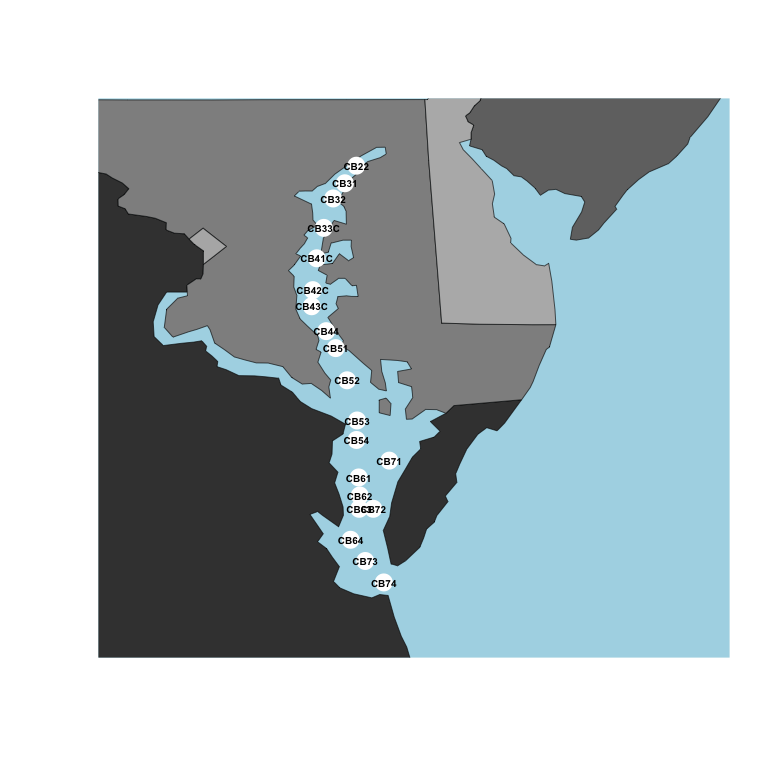

In [68]:
library(rworldmap)
library(rworldxtra)
library(maptools)
options(repr.plot.width=6.5, repr.plot.height=6.5)
subm <- env_data[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm, FUN=mean)

#newmap <- getMap(resolution = "high")
#plot(newmap, xlim = c(-77.5, -74.2), ylim = c(36.8, 39.5), asp = 1)

inFile <- '/Volumes/KeithSSD/CB_V4/map_data/cb_2015_us_state_20m.shp'
suppressWarnings(sPDF <- readShapePoly(inFile))
sPDF2 = sPDF[sPDF$NAME %in% c("Delaware", 'New Jersey', 'District of Columbia', 'Maryland', 'Virginia'),]
sPDF$NAME <- 'Hi'

mapPolys(sPDF2,nameColumnToPlot = "NAME", xlim = c(-77.5, -74.2), ylim = c(36.8, 39.5), 
         addLegend=F, borderCol='black', oceanCol='lightblue', colourPalette='white2Black', 
         catMethod='categorical', mapTitle="")
points(x=aggSub$Longitude, y=aggSub$Latitude, col="white", pch=16, cex=2)
text(x=aggSub$Longitude, y=aggSub$Latitude, labels=aggSub$StationName, cex=0.5, font=2, col='black')

In [71]:
cart_coords = as.data.frame(geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000))
rownames(cart_coords) <- aggSub$StationName

ENV.maxi[,'Xcoord'] <- NA; ENV.mini[,'Xcoord'] <- NA; 
ENV.maxi[,'Ycoord'] <- NA; ENV.mini[,'Ycoord'] <- NA;

for (stat_ in rownames(cart_coords)){
    stat_ind1 = rownames(ENV.maxi)[env_data$StationName == stat_]
    ENV.maxi[stat_ind1, "Xcoord"] <- cart_coords[stat_, 'X']
    ENV.maxi[stat_ind1, "Ycoord"] <- cart_coords[stat_, 'Y']
    stat_ind2 = intersect(stat_ind1, rownames(ENV.mini))
    ENV.mini[stat_ind2, "Xcoord"] <- cart_coords[stat_, 'X']
    ENV.mini[stat_ind2, "Ycoord"] <- cart_coords[stat_, 'Y']
}

cb.dbmem.maxi <- dbmem(ENV.maxi[,c('Xcoord', 'Ycoord')], thresh = 50.0 ,silent = FALSE)
cb.dbmem.mini <- dbmem(ENV.mini[,c('Xcoord', 'Ycoord')], thresh = 50.0 ,silent = FALSE)

User-provided truncation threshold = 50 
Time to compute dbMEMs = 0.168000  sec 
User-provided truncation threshold = 50 
Time to compute dbMEMs = 0.076000  sec 


[1] 290   4

[1] 180   4

In [87]:
OTU.maxi = OTU.clean[rownames(ENV.maxi),]
cap.pcnm.maxi <- capscale(OTU.maxi ~ ., data=as.data.frame(scores(cb.dbmem.maxi)), distance='bray')
mod0.pcnm.maxi <- capscale(OTU.maxi ~ 1, data=as.data.frame(scores(cb.dbmem.maxi)), distance='bray')
step.pcnm.maxi <- ordistep(mod0.pcnm.maxi, scope=formula(cap.pcnm.maxi), trace=F)
step.pcnm.maxi

Call: capscale(formula = OTU.maxi ~ MEM1 + MEM2 + MEM3, data =
as.data.frame(scores(cb.dbmem.maxi)), distance = "bray")

               Inertia Proportion Rank
Total         83.87627    1.00000     
Constrained    9.90404    0.11808    3
Unconstrained 76.34982    0.91027  197
Imaginary     -2.37759   -0.02835   92
Inertia is squared Bray distance 
Species scores projected from ‘OTU.maxi’ 

Eigenvalues for constrained axes:
 CAP1  CAP2  CAP3 
8.225 1.208 0.471 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
16.277  7.639  5.116  4.610  3.624  2.688  2.659  2.274 
(Showing 8 of 197 unconstrained eigenvalues)


In [88]:
OTU.mini = OTU.clean[rownames(ENV.mini),]

cap.pcnm.mini <- capscale(OTU.mini ~ ., data=as.data.frame(scores(cb.dbmem.mini)), distance='bray')
mod0.pcnm.mini <- capscale(OTU.mini ~ 1, data=as.data.frame(scores(cb.dbmem.mini)), distance='bray')
step.pcnm.mini <- ordistep(mod0.pcnm.mini, scope=formula(cap.pcnm.mini), trace=F)
step.pcnm.mini

Call: capscale(formula = OTU.mini ~ MEM1 + MEM2 + MEM3, data =
as.data.frame(scores(cb.dbmem.mini)), distance = "bray")

               Inertia Proportion Rank
Total         48.89565    1.00000     
Constrained    6.17476    0.12628    3
Unconstrained 43.56237    0.89093  134
Imaginary     -0.84149   -0.01721   45
Inertia is squared Bray distance 
Species scores projected from ‘OTU.mini’ 

Eigenvalues for constrained axes:
 CAP1  CAP2  CAP3 
4.584 1.095 0.495 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
13.157  4.282  2.738  2.549  1.934  1.611  1.337  1.116 
(Showing 8 of 134 unconstrained eigenvalues)


In [99]:
ad.mini = adonis(OTU.mini ~., data=ENV.mini, method='bray', permutations = 1000, parallel=3)
ad.mini$aov.tab[ad.mini$aov.tab[,'F.Model'] > 3,]

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
StatName,5,6.4856551,1.2971310,14.895751,0.132642785,0.000999001
Year,1,2.4039454,2.4039454,27.605979,0.049164811,0.000999001
Month,5,16.1046983,3.2209397,36.988025,0.329368735,0.000999001
Discharge_Susquehanna_14,1,0.4046816,0.4046816,4.647207,0.008276434,0.000999001
Latitude,1,0.3894163,0.3894163,4.471906,0.007964231,0.001998002
Longitude,1,0.3935368,0.3935368,4.519224,0.008048503,0.000999001
depth_segment,1,1.6737447,1.6737447,19.220636,0.034230952,0.000999001
habitat,2,1.2016540,0.6008270,6.899665,0.024575889,0.000999001
enspie,1,0.4634706,0.4634706,5.322317,0.009478770,0.000999001


In [100]:
ad.Maxi = adonis(OTU.maxi ~., data=ENV.maxi, method='bray', permutations = 1000, parallel=3)
ad.Maxi$aov.tab[ad.Maxi$aov.tab[,'F.Model'] > 3,]


,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
StatName,5,11.5044358,2.3008872,19.134406,0.137159596,0.000999001
Year,2,5.5207770,2.7603885,22.955665,0.065820485,0.000999001
Month,5,19.5595665,3.9119133,32.531859,0.233195464,0.000999001
Discharge_Susquehanna_14,1,0.7669967,0.7669967,6.378420,0.009144382,0.000999001
Latitude,1,0.4270984,0.4270984,3.551793,0.005092005,0.000999001
Longitude,1,0.3933316,0.3933316,3.270984,0.004689426,0.001998002
depth_segment,2,2.5997181,1.2998590,10.809757,0.030994678,0.000999001
habitat,2,1.7910754,0.8955377,7.447380,0.021353779,0.000999001
enspie,1,1.2623331,1.2623331,10.497688,0.015049943,0.000999001


In [316]:
ENV.maxi.2 <- subset(ENV.maxi, select=-c(Xcoord, Ycoord, Month_Year, CollectionAgency, Longitude,
                                         TrimCount, SalZone, habitat, depth_float, depth_segment))

cap.env.maxi <- capscale(OTU.maxi ~ ., data=ENV.maxi.2, distance='bray')
mod0.env.maxi <- capscale(OTU.maxi ~ 1, data=ENV.maxi.2, distance='bray')
step.env.maxi <- ordiR2step(mod0.env.maxi, scope=formula(cap.env.maxi), direction ="forward", 
                            permutations = how(nperm = 99), trace = TRUE, R2permutations = 299)


Step: R2.adj= 0 
Call: OTU.maxi ~ 1 
 
                           R2.adjusted
<All variables>             0.54346801
+ Month                     0.25330005
+ anti_day_length           0.16265308
+ WTEMP                     0.14432943
+ Discharge_Susquehanna_14  0.13640953
+ StatName                  0.12233073
+ Latitude                  0.09892714
+ faith_pd                  0.09634104
+ SALINITY                  0.09379545
+ AC_PrinComp2              0.07797374
+ Year                      0.07231021
+ day_length                0.05534752
+ enspie                    0.05475733
+ AC_PrinComp1              0.04997782
+ DO                        0.04394767
<none>                      0.00000000

        Df    AIC      F Pr(>F)   
+ Month  5 1216.7 19.841   0.01 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: R2.adj= 0.2533 
Call: OTU.maxi ~ Month 
 
                           R2.adjusted
<All variables>              0.5434680
+ StatName                   0.36

In [317]:
ENV.mini.2 <- subset(ENV.mini, select=-c(Xcoord, Ycoord, Month_Year, CollectionAgency, Longitude, 
                                         TrimCount, SalZone, habitat, depth_float, depth_segment))

cap.env.mini <- capscale(OTU.mini ~ ., data=ENV.mini.2, distance='bray')
mod0.env.mini <- capscale(OTU.mini ~ 1, data=ENV.mini.2, distance='bray')
step.env.mini <- ordiR2step(mod0.env.mini, scope=formula(cap.env.mini), direction ="forward", 
                            permutations = how(nperm = 99), trace = TRUE, R2permutations = 299)

Step: R2.adj= 0 
Call: OTU.mini ~ 1 
 
                           R2.adjusted
<All variables>             0.66416205
+ Month                     0.33897803
+ anti_day_length           0.24836086
+ WTEMP                     0.22359913
+ Discharge_Susquehanna_14  0.21097208
+ faith_pd                  0.17012953
+ StatName                  0.10810394
+ SALINITY                  0.10266100
+ TP                        0.09452872
+ AC_PrinComp1              0.08803031
+ Latitude                  0.08706204
+ enspie                    0.07611051
+ AC_PrinComp2              0.07200688
+ DO                        0.06914546
+ DOP                       0.06823182
+ TDN                       0.06560607
+ day_length                0.05441885
+ NO3F                      0.04981389
+ Year                      0.04450903
+ PC                        0.04307196
+ NH4F                      0.03486188
+ CHLA                      0.03235970
+ PHEO                      0.03026921
+ NO2F                   

In [455]:
adj.r.squared <- function(rss,tss, n, k) {(1 - ((1-(rss/(tss)))*((n-1)/(n-(k+1)))))}
maxi_chosen_cols = c('Month', 'Year', 'StatName', 'faith_pd', 'enspie', 'SALINITY')
ENV.maxi.3 = ENV.maxi.2[,maxi_chosen_cols]

#ad.maxi.bc = adonis(OTU.maxi ~ Month*Year + StatName + faith_pd*enspie + SALINITY, data=ENV.maxi.3, 
#                    method='bray', permutations = 1000, parallel=3)
ad.maxi.bc
print(adj.r.squared(ad.maxi.bc$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2+1], 
                    ad.maxi.bc$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2+2], 
                    290, sum(ad.maxi.bc$aov.tab$Df[1:length(maxi_chosen_cols)+2])))

#ad.maxi.bc.2 = adonis(OTU.maxi ~. , data=ENV.maxi.3, method='bray', permutations = 1000, parallel=3)
ad.maxi.bc.2
print(adj.r.squared(ad.maxi.bc.2$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+1], 
                    ad.maxi.bc.2$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2], 
                    290, sum(ad.maxi.bc.2$aov.tab$Df[1:length(maxi_chosen_cols)])))

#ad.maxi.uf = adonis(wunifrac_dist ~ Month*Year + StatName + faith_pd*enspie + SALINITY, 
#                    data=ENV.maxi.3, permutations = 1000, parallel=3)
ad.maxi.uf
print(adj.r.squared(ad.maxi.uf$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2+1], 
                    ad.maxi.uf$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2+2], 
                    290, sum(ad.maxi.uf$aov.tab$Df[1:length(maxi_chosen_cols)+2])))

#ad.maxi.uf.2 = adonis(wunifrac_dist~., data=ENV.maxi.3, permutations = 1000, parallel=3)
ad.maxi.uf.2
print(adj.r.squared(ad.maxi.uf.2$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+1], 
                    ad.maxi.uf.2$aov.tab$SumsOfSqs[length(maxi_chosen_cols)+2], 
                    290, sum(ad.maxi.uf.2$aov.tab$Df[1:length(maxi_chosen_cols)])))


#cap.env.maxi.bc <- capscale(OTU.maxi ~ ., data=ENV.maxi.3, distance='bray')
#cap.env.maxi.uf <- capscale(wunifrac_dist ~., data=ENV.maxi.3)

cap.env.maxi.bc.anova = anova(cap.env.maxi.bc)
adj.r.squared(cap.env.maxi.bc.anova$SumOfSqs[1], sum(cap.env.maxi.bc.anova$SumOfSqs), 290, 15)
cap.env.maxi.bc

cap.env.mini.uf.anova = anova(cap.env.mini.uf)
adj.r.squared(cap.env.mini.uf.anova$SumOfSqs[1], sum(cap.env.mini.uf.anova$SumOfSqs), 290, 15)
cap.env.maxi.uf



Call:
adonis(formula = OTU.maxi ~ Month * Year + StatName + faith_pd *      enspie + SALINITY, data = ENV.maxi.3, permutations = 1000,      method = "bray", parallel = 3) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

                 Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Month             5    22.321  4.4642  32.567 0.26612 0.000999 ***
Year              2     5.391  2.6955  19.664 0.06427 0.000999 ***
StatName          5     8.873  1.7746  12.946 0.10579 0.000999 ***
faith_pd          1     2.289  2.2892  16.700 0.02729 0.000999 ***
enspie            1     2.150  2.1503  15.687 0.02564 0.000999 ***
SALINITY          1     2.278  2.2780  16.619 0.02716 0.000999 ***
Month:Year        3     2.721  0.9069   6.616 0.03244 0.000999 ***
faith_pd:enspie   1     0.843  0.8428   6.149 0.01005 0.000999 ***
Residuals       270    37.010  0.1371         0.44125             
Total           289    83.876                 1.00000             

[1] 0.4170441



Call:
adonis(formula = OTU.maxi ~ ., data = ENV.maxi.3, permutations = 1000,      method = "bray", parallel = 3) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Month       5    22.321  4.4642  30.147 0.26612 0.000999 ***
Year        2     5.391  2.6955  18.203 0.06427 0.000999 ***
StatName    5     8.873  1.7746  11.984 0.10579 0.000999 ***
faith_pd    1     2.289  2.2892  15.459 0.02729 0.000999 ***
enspie      1     2.150  2.1503  14.521 0.02564 0.000999 ***
SALINITY    1     2.278  2.2780  15.383 0.02716 0.000999 ***
Residuals 274    40.574  0.1481         0.48374             
Total     289    83.876                 1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 0.4554743



Call:
adonis(formula = wunifrac_dist ~ Month * Year + StatName + faith_pd *      enspie + SALINITY, data = ENV.maxi.3, permutations = 1000,      parallel = 3) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

                 Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Month             5    5.7475 1.14949  23.769 0.19749 0.000999 ***
Year              2    2.3807 1.19037  24.614 0.08181 0.000999 ***
StatName          5    2.5062 0.50123  10.364 0.08612 0.000999 ***
faith_pd          1    1.2395 1.23949  25.630 0.04259 0.000999 ***
enspie            1    0.9119 0.91192  18.857 0.03134 0.000999 ***
SALINITY          1    1.5210 1.52096  31.450 0.05226 0.000999 ***
Month:Year        3    1.2196 0.40652   8.406 0.04191 0.000999 ***
faith_pd:enspie   1    0.5182 0.51819  10.715 0.01781 0.000999 ***
Residuals       270   13.0575 0.04836         0.44868             
Total           289   29.1020                 1.00000             
---
Signif.

[1] 0.4247967



Call:
adonis(formula = wunifrac_dist ~ ., data = ENV.maxi.3, permutations = 1000,      parallel = 3) 

Permutation: free
Number of permutations: 1000

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)    
Month       5    5.7475 1.14949 21.2880 0.19749 0.000999 ***
Year        2    2.3807 1.19037 22.0449 0.08181 0.000999 ***
StatName    5    2.5062 0.50123  9.2826 0.08612 0.000999 ***
faith_pd    1    1.2395 1.23949 22.9546 0.04259 0.000999 ***
enspie      1    0.9119 0.91192 16.8883 0.03134 0.000999 ***
SALINITY    1    1.5210 1.52096 28.1673 0.05226 0.000999 ***
Residuals 274   14.7953 0.05400         0.50839             
Total     289   29.1020                 1.00000             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 0.4814805


[1] 0.4754215

Call: capscale(formula = OTU.maxi ~ Month + Year + StatName + faith_pd
+ enspie + SALINITY, data = ENV.maxi.3, distance = "bray")

               Inertia Proportion Rank
Total         83.87627    1.00000     
Constrained   43.35539    0.51690   15
Unconstrained 42.89847    0.51145  197
Imaginary     -2.37759   -0.02835   92
Inertia is squared Bray distance 
Species scores projected from ‘OTU.maxi’ 

Eigenvalues for constrained axes:
  CAP1   CAP2   CAP3   CAP4   CAP5   CAP6   CAP7   CAP8   CAP9  CAP10  CAP11 
14.943 10.320  4.995  3.666  2.196  1.934  1.246  0.931  0.825  0.725  0.574 
 CAP12  CAP13  CAP14  CAP15 
 0.433  0.370  0.128  0.071 

Eigenvalues for unconstrained axes:
 MDS1  MDS2  MDS3  MDS4  MDS5  MDS6  MDS7  MDS8 
4.746 2.842 2.529 2.374 1.955 1.653 1.494 1.329 
(Showing 8 of 197 unconstrained eigenvalues)


[1] 0.5357185

Call: capscale(formula = wunifrac_dist ~ Month + Year + StatName +
faith_pd + enspie + SALINITY, data = ENV.maxi.3)

              Inertia Proportion Rank
Total         29.1020     1.0000     
Constrained   14.4811     0.4976   15
Unconstrained 18.3221     0.6296  130
Imaginary     -3.7012    -0.1272  159
Inertia is squared Unknown distance 

Eigenvalues for constrained axes:
 CAP1  CAP2  CAP3  CAP4  CAP5  CAP6  CAP7  CAP8  CAP9 CAP10 CAP11 CAP12 CAP13 
4.927 3.005 2.483 1.445 0.673 0.504 0.449 0.325 0.212 0.167 0.115 0.065 0.051 
CAP14 CAP15 
0.037 0.022 

Eigenvalues for unconstrained axes:
 MDS1  MDS2  MDS3  MDS4  MDS5  MDS6  MDS7  MDS8 
3.986 2.249 1.542 1.206 0.834 0.743 0.642 0.473 
(Showing 8 of 130 unconstrained eigenvalues)


In [453]:
mini_chosen_cols = c('Month', 'Year', 'SALINITY', 'NO3F', 'TP', 'DO', 'AC_PrinComp2', 'NO2F')
ENV.mini.3 = ENV.mini.2[,mini_chosen_cols]
#ad.mini.bc = adonis(OTU.mini ~ Month*Year + SALINITY + NO3F + TP + DO + AC_PrinComp2, data=ENV.mini.3, 
#                    method='bray', permutations = 1000, parallel=3)
#ad.mini.bc
print(adj.r.squared(ad.mini.bc$aov.tab$SumsOfSqs[length(mini_chosen_cols)+1], 
                    ad.mini.bc$aov.tab$SumsOfSqs[length(mini_chosen_cols)+2], 
                    180, sum(ad.mini.bc$aov.tab$Df[1:8])))

#ad.mini.bc.2 = adonis(OTU.mini ~., data=ENV.mini.3[,1:7], method='bray', permutations = 1000, parallel=3)
#ad.mini.bc.2
print(adj.r.squared(ad.mini.bc.2$aov.tab$SumsOfSqs[8], 
                    ad.mini.bc.2$aov.tab$SumsOfSqs[9], 
                    180, sum(ad.mini.bc.2$aov.tab$Df[1:7])))

sub_wUF = as.dist(as.matrix(wunifrac_dist)[rownames(ENV.mini.3), rownames(ENV.mini.3)])
#ad.mini.uf = adonis(sub_wUF ~ Month*Year + SALINITY + NO3F + TP + DO + AC_PrinComp2, data=ENV.mini.3, 
#                    permutations = 1000, parallel=3)

#ad.mini.uf
print(adj.r.squared(ad.mini.uf$aov.tab$SumsOfSqs[length(mini_chosen_cols)+1], 
                    ad.mini.uf$aov.tab$SumsOfSqs[length(mini_chosen_cols)+2], 
                    180, sum(ad.mini.uf$aov.tab$Df[1:8])))
#ad.mini.uf.2 = adonis(sub_wUF ~., data=ENV.mini.3[,1:7], permutations = 1000, parallel=3)
#ad.mini.uf.2
print(adj.r.squared(ad.mini.uf.2$aov.tab$SumsOfSqs[8], 
                    ad.mini.uf.2$aov.tab$SumsOfSqs[9], 
                    180, sum(ad.mini.uf.2$aov.tab$Df[1:7])))

cap.env.mini.bc <- capscale(OTU.mini ~ ., data=ENV.mini.3[,1:7], distance='bray')
cap.env.mini.uf <- capscale(sub_wUF ~., data=ENV.mini.3[,1:7])
cap.env.mini.uf.anova = anova(cap.env.mini.uf)
adj.r.squared(cap.env.mini.uf.anova$SumOfSqs[1], sum(cap.env.mini.uf.anova$SumOfSqs), 180, 17)
cap.env.mini.uf
cap.env.mini.bc.anova = anova(cap.env.mini.bc)
adj.r.squared(cap.env.mini.bc.anova$SumOfSqs[1], sum(cap.env.mini.bc.anova$SumOfSqs), 180, 17)
cap.env.mini.bc

[1] 0.3558635
[1] 0.3694218
[1] 0.3320431
[1] 0.3445016


[1] 0.5309946

Call: capscale(formula = sub_wUF ~ Month + Year + SALINITY + NO3F + TP
+ DO + AC_PrinComp2, data = ENV.mini.3[, 1:7])

              Inertia Proportion Rank
Total         15.6535     1.0000     
Constrained    9.6923     0.6192   11
Unconstrained  7.6210     0.4869   89
Imaginary     -1.6598    -0.1060   90
Inertia is squared Unknown distance 

Eigenvalues for constrained axes:
 CAP1  CAP2  CAP3  CAP4  CAP5  CAP6  CAP7  CAP8  CAP9 CAP10 CAP11 
3.713 2.357 1.603 0.662 0.450 0.284 0.270 0.163 0.105 0.048 0.039 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
1.3190 1.0351 0.6403 0.5319 0.4540 0.3320 0.2583 0.2334 
(Showing 8 of 89 unconstrained eigenvalues)


[1] 0.5546688

Call: capscale(formula = OTU.mini ~ Month + Year + SALINITY + NO3F + TP
+ DO + AC_PrinComp2, data = ENV.mini.3[, 1:7], distance = "bray")

               Inertia Proportion Rank
Total         48.89565    1.00000     
Constrained   28.94878    0.59205   11
Unconstrained 20.78836    0.42516  134
Imaginary     -0.84149   -0.01721   45
Inertia is squared Bray distance 
Species scores projected from ‘OTU.mini’ 

Eigenvalues for constrained axes:
  CAP1   CAP2   CAP3   CAP4   CAP5   CAP6   CAP7   CAP8   CAP9  CAP10  CAP11 
12.493  5.670  3.184  2.298  1.640  1.056  0.845  0.618  0.529  0.352  0.264 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
2.2491 1.6442 1.2161 1.0913 1.0332 0.7917 0.7486 0.6332 
(Showing 8 of 134 unconstrained eigenvalues)



Partition of variance in RDA 

Call: varpart(Y = OTU.mini, X = ~Month + Year, ~SALINITY, ~TP +
AC_PrinComp2 + NO3F + DO, cb.spatial.mini, data = ENV.mini)

Explanatory tables:
X1:  ~Month + Year
X2:  ~SALINITY
X3:  ~TP + AC_PrinComp2 + NO3F + DO
X4:  cb.spatial.mini 

No. of explanatory tables: 4 
Total variation (SS): 27869408 
            Variance: 155695 
No. of observations: 180 

Partition table:
                            Df R.square Adj.R.square Testable
[aeghklno] = X1              6  0.30419      0.28006     TRUE
[befiklmo] = X2              1  0.07128      0.06606     TRUE
[cfgjlmno] = X3              4  0.21973      0.20190     TRUE
[dhijkmno] = X4              3  0.10572      0.09048     TRUE
[abefghiklmno] = X1+X2       7  0.37068      0.34506     TRUE
[acefghjklmno] = X1+X3      10  0.48022      0.44947     TRUE
[adeghijklmno] = X1+X4       9  0.40856      0.37725     TRUE
[bcefgijklmno] = X2+X3       5  0.26919      0.24819     TRUE
[bdefhijklmno] = X2+X4       4  0.16

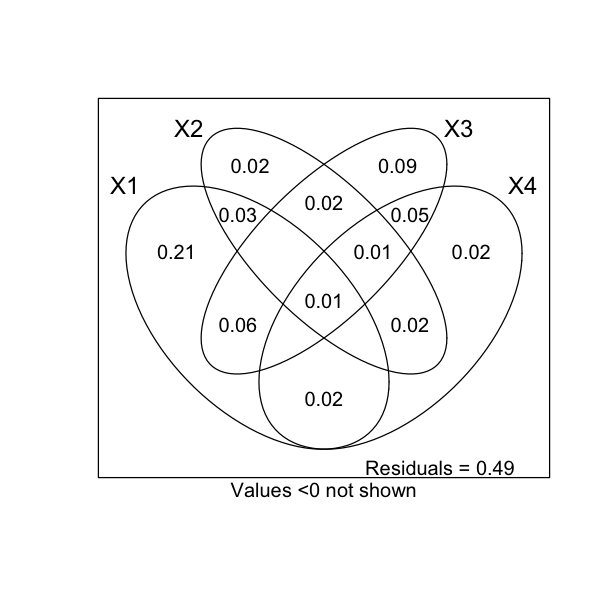

In [346]:
# Month_Year >> Month
# Year << all other predictor combintations tested 

cb.spatial.mini <- scores(cb.dbmem.mini, choices=c(1:3))

cb.varpart.mini <- varpart(OTU.mini, 
                           ~Month + Year,
                           ~SALINITY,
                           ~ TP + AC_PrinComp2 + NO3F + DO,
                            cb.spatial.mini, data=ENV.mini)

options(repr.plot.width=5, repr.plot.height=5)
plot(cb.varpart.mini)
cb.varpart.mini

In [347]:
anova(rda(OTU.mini ~ cb.spatial.mini + ENV.mini.3$Year + 
                     ENV.mini.3$Month + ENV.mini.3$NO3F + ENV.mini.3$SALINITY + 
                     ENV.mini.3$DO + ENV.mini.3$AC_PrinComp2 + 
                     ENV.mini.3$TP))

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,14,85149.31,14.22547,0.001
Residual,165,70545.70,NA,NA


In [348]:
anova(rda(OTU.mini ~ Month + Year + Condition(ENV.mini.3$NO3F) + Condition(ENV.mini.3$SALINITY) +  
          Condition(ENV.mini.3$TP) + Condition(ENV.mini.3$DO) + Condition(ENV.mini.3$AC_PrinComp2) +
          Condition(cb.spatial.mini),data=ENV.mini.3))

anova(rda(OTU.mini ~ SALINITY + Condition(ENV.mini.3$Year) + Condition(ENV.mini.3$Month) + 
          Condition(ENV.mini.3$NO3F) + Condition(ENV.mini.3$TP) + 
          Condition(ENV.mini.3$DO) + Condition(ENV.mini.3$AC_PrinComp2) + Condition(cb.spatial.mini), 
          data=ENV.mini.3))

anova(rda(OTU.mini ~ NO3F + DO + TP + AC_PrinComp2 + Condition(ENV.mini.3$Year) + 
          Condition(ENV.mini.3$Month) + Condition(cb.spatial.mini) + Condition(ENV.mini.3$SALINITY),
          data=ENV.mini.3))

anova(rda(OTU.mini ~ cb.spatial.mini  + Condition(ENV.mini.3$SALINITY) + Condition(ENV.mini.3$Year) + 
          Condition(ENV.mini.3$Month) + Condition(ENV.mini.3$NO3F) + Condition(ENV.mini.3$TP) + 
          Condition(ENV.mini.3$DO) + Condition(ENV.mini.3$AC_PrinComp2), data=ENV.mini.3))




,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,6,33989.05,13.24955,0.001
Residual,165,70545.70,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,2682.748,6.274704,0.001
Residual,165,70545.702,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,4,15108.3,8.834236,0.001
Residual,165,70545.7,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,4820.151,3.757965,0.001
Residual,165,70545.702,NA,NA



Partition of variance in RDA 

Call: varpart(Y = OTU.maxi, X = ~Month + Year, ~faith_pd + enspie,
~StatName, ~SALINITY, data = ENV.maxi)

Explanatory tables:
X1:  ~Month + Year
X2:  ~faith_pd + enspie
X3:  ~StatName
X4:  ~SALINITY 

No. of explanatory tables: 4 
Total variation (SS): 51758715 
            Variance: 179096 
No. of observations: 290 

Partition table:
                            Df R.square Adj.R.square Testable
[aeghklno] = X1              7  0.23640      0.21745     TRUE
[befiklmo] = X2              2  0.14288      0.13690     TRUE
[cfgjlmno] = X3              5  0.09458      0.07863     TRUE
[dhijkmno] = X4              1  0.05480      0.05152     TRUE
[abefghiklmno] = X1+X2       9  0.32623      0.30457     TRUE
[acefghjklmno] = X1+X3      12  0.32106      0.29165     TRUE
[adeghijklmno] = X1+X4       8  0.28049      0.26000     TRUE
[bcefgijklmno] = X2+X3       7  0.23025      0.21114     TRUE
[bdefhijklmno] = X2+X4       3  0.19472      0.18628     TRUE
[cdfghijkl

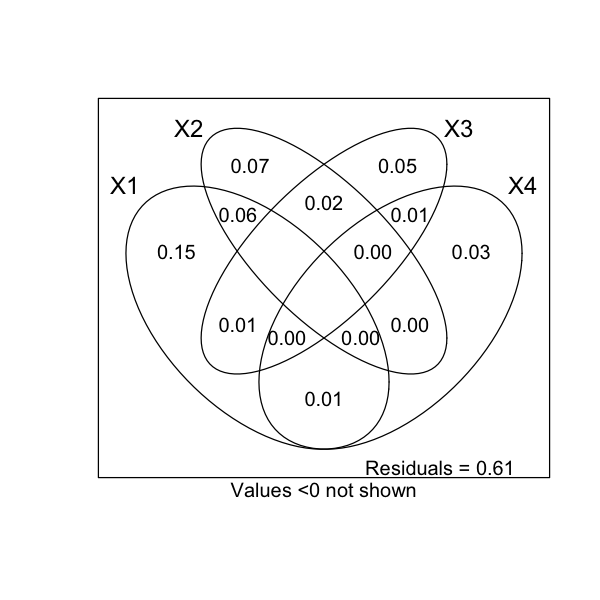

In [460]:
# Month_Year >> Month
# Year << all other predictor combintations tested 

cb.spatial.maxi <- scores(cb.dbmem.maxi, choices=c(1:3))

cb.varpart.maxi <- varpart(OTU.maxi, 
                           ~ Month + Year,
                           ~ faith_pd + enspie,
                           ~ StatName, 
                            ~ SALINITY, data=ENV.maxi)
cb.varpart.maxi
options(repr.plot.width=5, repr.plot.height=5)
plot(cb.varpart.maxi)


In [461]:
anova(rda(OTU.maxi ~ Month + Year + 
          faith_pd + enspie +  
          SALINITY + 
          StatName, data=ENV.maxi.3))

anova(rda(OTU.maxi ~ Month + Year + 
          Condition(ENV.maxi.3$faith_pd) + Condition(ENV.maxi.3$enspie) +  
          Condition(ENV.maxi.3$StatName) + 
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ faith_pd + enspie + 
          Condition(ENV.maxi.3$Year) + Condition(ENV.maxi.3$Month) + 
          Condition(ENV.maxi.3$StatName) + 
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ StatName + 
          Condition(ENV.maxi.3$Month) + Condition(ENV.maxi.3$Year) + 
          Condition(ENV.maxi.3$enspie) + Condition(ENV.maxi.3$faith_pd) +
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ SALINITY  + 
          Condition(ENV.maxi.3$Year) + Condition(ENV.maxi.3$Month) + 
          Condition(ENV.maxi.3$faith_pd) + Condition(ENV.maxi.3$enspie) + 
          Condition(ENV.maxi.3$StatName), data=ENV.maxi.3))


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,15,75843.75,13.41776,0.001
Residual,274,103252.15,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,7,28287.42,10.72375,0.001
Residual,274,103252.15,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,2,12791.18,16.97197,0.001
Residual,274,103252.15,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,5,9930.504,5.270511,0.001
Residual,274,103252.153,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,5178.627,13.74251,0.001
Residual,274,103252.153,NA,NA


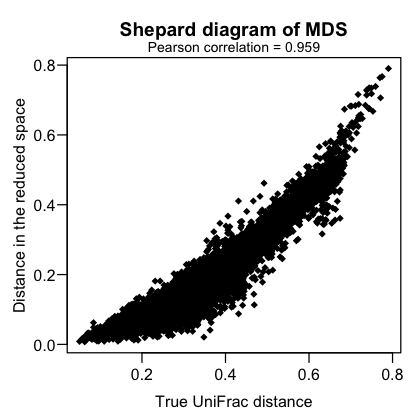

In [380]:
set.seed(100)
wUF.nmds.3D = metaMDS(wunifrac_dist, method="NMDS", k=3, trymax=1000, trace=0)
swUF.nmds.3D = metaMDS(sub_wUF, method="NMDS", k=3, trymax=1000, trace=0)

options(repr.plot.width=3.5, repr.plot.height=3.5)
par(mfrow = c(1,1), mar = c(3.5,3.5,3,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
spear <- round(cor(sub_wUF, dist(swUF.nmds.3D$points), method = "pearson"),3)
plot(sub_wUF, dist(swUF.nmds.3D$points), main = "Shepard diagram of MDS", 
     xlab = "True UniFrac distance", ylab = "Distance in the reduced space", pch=18)
mtext(line = 0.1, text = paste0("Pearson correlation = ", spear), cex = 0.7)


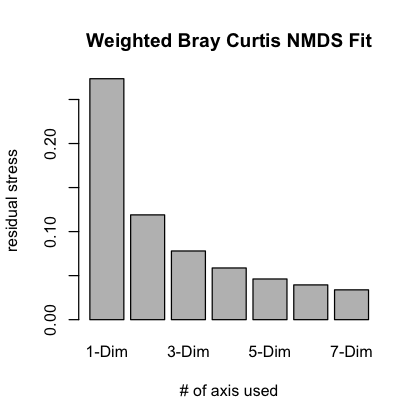

In [363]:
n = 7
stress <- rep(0, n)
for (i in 1:n) {
    stress[i] <- metaMDS(sub_wUF, trymax=1000, k = i, trace=0)$stress
}
names(stress) <- paste(1:n, "Dim", sep="-")
par(cex=0.8)
barplot(stress, ylab = "residual stress", xlab='# of axis used')
title('Weighted UniFrac NMDS Fit')

In [427]:
fit.swUF = envfit(swUF.nmds.3D, ENV.mini.3[,  c('NO3F', 'NO2F', 'TP', 'DO', 'AC_PrinComp2')])
fit.swUF2 = envfit(swUF.nmds.3D, ENV.mini.3[, c('NO3F', 'TP','DO', 'AC_PrinComp2', 'SALINITY')], choices=c(1,3))
fit.swUF
fit.swUF2
fit.wUF = envfit(wUF.nmds.3D, ENV.maxi.3[,c("SALINITY", 'faith_pd', 'enspie')])
fit.wUF2 = envfit(wUF.nmds.3D, ENV.maxi.3[,c("SALINITY", 'faith_pd', 'enspie')], choices=c(1,3))




***VECTORS

                NMDS1    NMDS2     r2 Pr(>r)    
NO3F          0.75381 -0.65709 0.1183  0.001 ***
NO2F         -0.58406 -0.81171 0.1125  0.001 ***
TP           -0.37079 -0.92872 0.5137  0.001 ***
DO            0.33367  0.94269 0.4664  0.001 ***
AC_PrinComp2 -0.09111 -0.99584 0.1264  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999




***VECTORS

                NMDS1    NMDS3     r2 Pr(>r)    
NO3F          0.30229  0.95322 0.3963  0.001 ***
TP           -0.57382  0.81898 0.1665  0.001 ***
DO            0.99048  0.13768 0.0662  0.002 ** 
AC_PrinComp2 -0.03720  0.99931 0.4279  0.001 ***
SALINITY      0.01385 -0.99990 0.7418  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999



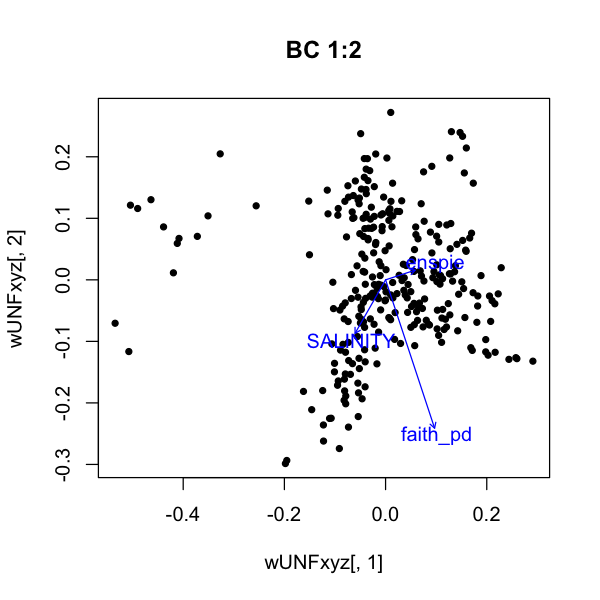

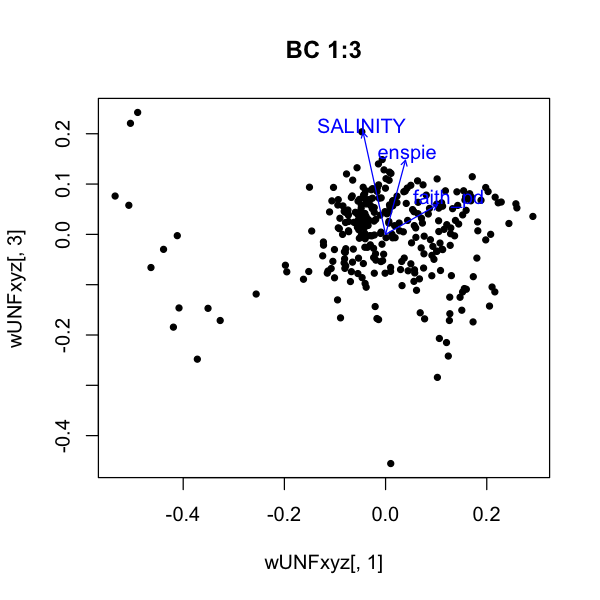

In [372]:
options(repr.plot.width=5, repr.plot.height=5)

wUNFxyz = scores(wUF.nmds.3D, display="sites")

plot(wUNFxyz[,1], wUNFxyz[,2], main="BC 1:2", pch=20)
plot(fit.wUF, add=T)
plot(wUNFxyz[,1], wUNFxyz[,3], main="BC 1:3", pch=20)
plot(fit.wUF2, add=T)

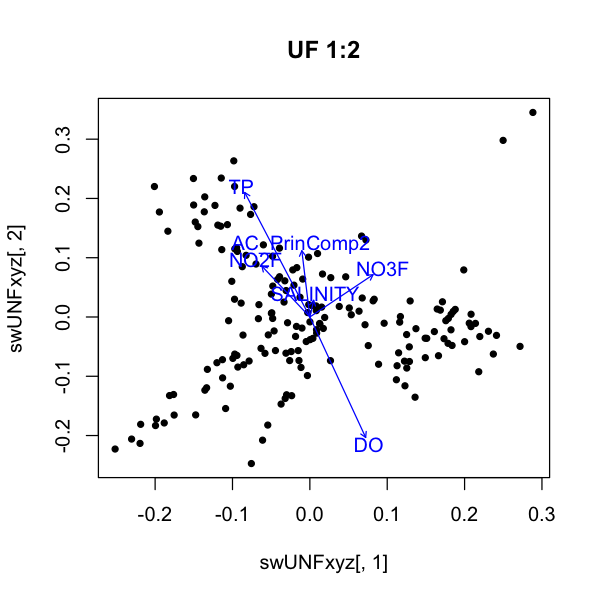

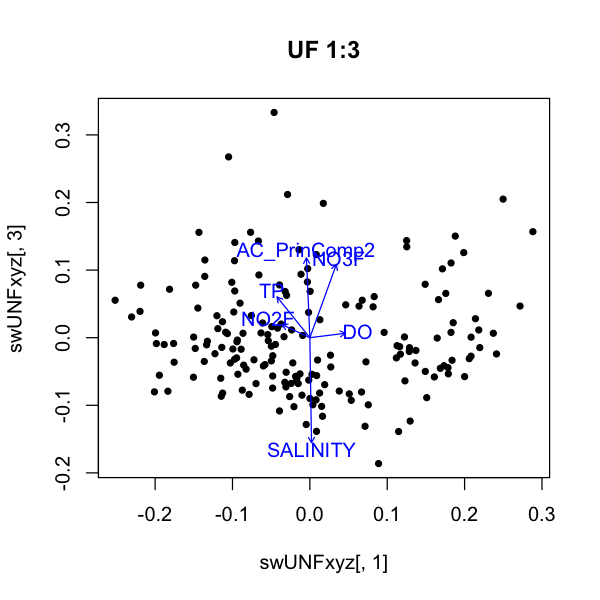

In [374]:
swUNFxyz = scores(swUF.nmds.3D, display="sites")

plot(swUNFxyz[,1], swUNFxyz[,2], main="UF 1:2", pch=20)
plot(fit.swUF, add=T)
plot(swUNFxyz[,1], swUNFxyz[,3], main="UF 1:3", pch=20)
plot(fit.swUF2, add=T)

,NMDS1,NMDS2
NO3F,0.12965316,-0.1130187
NO2F,-0.09794714,-0.1361230
TP,-0.13288048,-0.3328271
DO,0.11393370,0.3218915
AC_PrinComp2,-0.01619536,-0.1770136


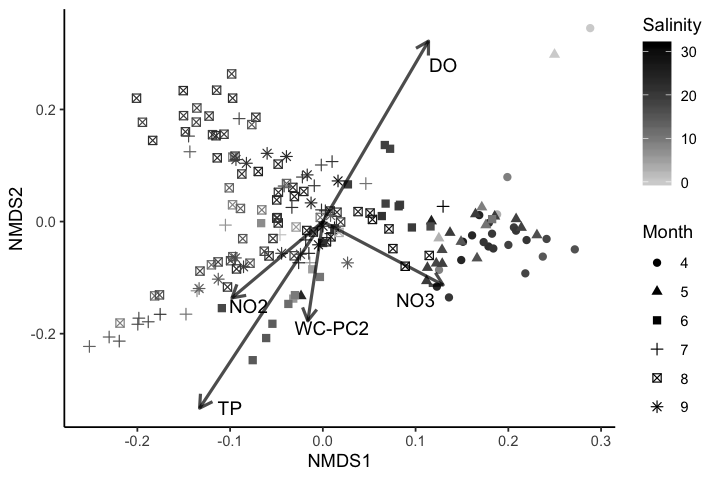

In [428]:
library(RColorBrewer)

mini.vectors.12 = c('NO3F', 'NO2F', 'AC_PrinComp2', 'DO', 'TP')
mini.aes = c('Month', 'SALINITY')
plot.df.mini = cbind.data.frame(swUNFxyz, ENV.mini.3[,mini.aes])
colnames(plot.df.mini) <- c('NMDS1', 'NMDS2', 'NMDS3', 'Month', 'Salinity')

spp.scrs <- as.data.frame(scores(fit.swUF, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*0.5})
spp.scrs

options(repr.plot.width=6, repr.plot.height=4)
sp2<-ggplot(plot.df.mini, aes(x=NMDS1, y=NMDS2, color=Salinity, shape=Month)) + theme_classic() + 
              geom_point(size=2) +   scale_colour_gradient(low = "lightgrey", high = "black") + 
             annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                      colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
             annotate("text", x = c(0.10, -0.08, -0.10, 0.13, 0.01), 
                              y = c(-0.14, -0.15, -0.3328, 0.28, -0.19), 
                              label = c('NO3', 'NO2', 'TP', 'DO', "WC-PC2"), 
                      color='black', alpha=1.0, size=4)
sp2

,NMDS1,NMDS3
NO3F,0.057087556,0.18001815
TP,-0.070248420,0.10026232
DO,0.076436474,0.01062529
AC_PrinComp2,-0.007299234,0.19609742
SALINITY,0.003579810,-0.25835946


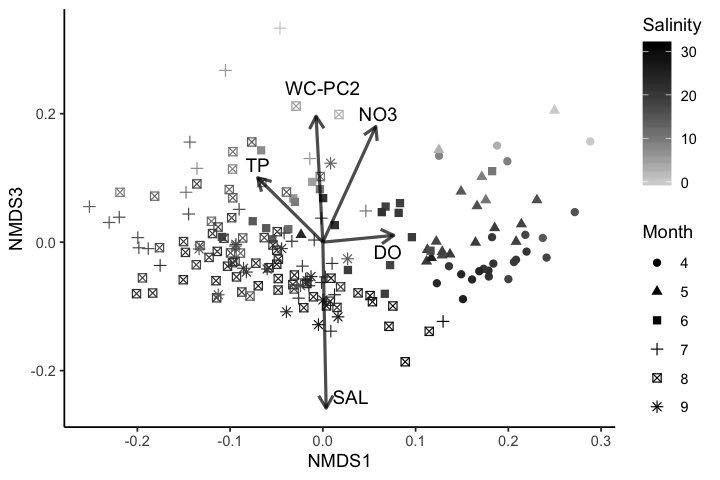

In [445]:
mini.vectors.13 = c('NO3F', 'TP','DO', 'AC_PrinComp2', 'SALINITY')
spp.scrs <- as.data.frame(scores(fit.swUF2, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*0.3})
spp.scrs


sp3 <-ggplot(plot.df.mini, aes(x=NMDS1, y=NMDS3, color=Salinity, shape=Month)) + theme_classic() + 
              geom_point(size=2) +   scale_colour_gradient(low = "lightgrey", high = "black") +
             annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS3'], 
                      alpha=0.7, colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
              annotate("text", x = c(.06, -0.07, 0.07, 0.0, 0.03), 
                               y = c(0.20, 0.12, -0.015, 0.24, -0.24), 
                               label = c('NO3', 'TP', "DO", 'WC-PC2', 'SAL'), 
                               color='black', size=4)
sp3



In [ ]:
ps.rarefied = rarefy_even_depth(ps, rngseed=1, sample.size=0.9*min(sample_sums(ps)), replace=F)

In [ ]:
BC.nmds.3D = metaMDS(OTU.clean2, distance="bray", k=3, trymax=1000)

In [ ]:
OTU.UF = otu_table(as.matrix(OTU.clean), taxa_are_rows=FALSE)
tax.UF = tax_table(as.matrix(tax.clean))
meta.UF = sample_data(meta)
wUF.dist = UniFrac(physeq.tree, weighted=TRUE, normalized=TRUE)
BC.nmds

In [ ]:
BC.nmds = metaMDS(OTU.clean, distance="bray", k=2, trymax=1000)
fit.BC = envfit(BC.nmds, meta[,c("AgeGroup", "ADGKG")])
fit.BC.OTU = envfit(BC.nmds, OTU.clean[,1:10])

In [ ]:
adonis(BC.dist ~ AgeGroup*ADGKG, data = meta, permutations = 1000)
adonis(uwUF.dist ~ AgeGroup*ADGKG, data=meta, permutations = 1000)
permutest(disp.age, pairwise=TRUE, permutations=1000)
simper(OTU.clean, meta$AgeGroup, permutations=100)
kruskal.test(OTU.clean$Otu00001 ~ meta$AgeGroup)
#Note: These P-values have not been corrected from false discovery rate (fdr) yet.



In [ ]:

KW.results = data.frame(read.csv("Age_krusk_simper.csv"))
#Remove non-significant
KW.results.signif = KW.results[KW.results$fdr_krusk_p.val < 0.05,]
#Order by OTU#
KW.results.signif = KW.results.signif[with(KW.results.signif, order(OTU)),]
head(KW.results.signif)